In [19]:
%%capture
from pathlib import Path

if Path.cwd().stem == "features":
    %cd ../..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import polars as pl
from icecream import ic
from polars import col

from src.database.database_manager import DatabaseManager
from src.database.quality_checks import check_sample_rate
from src.features.resampling import interpolate_and_fill_nulls
from src.features.scaling import scale_min_max, scale_robust_standard
from src.features.transforming import map_trials
from src.log_config import configure_logging

configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [21]:
db = DatabaseManager()

In [77]:
SAMPLE_RATE = 100

In [85]:
with db:
    ppg = db.get_table("Feature_PPG")
ppg = ppg.filter(col("trial_id") < 20)
ppg

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,ppg_raw,ppg_heartrate,ppg_ibi,ppg_clean,ppg_rate,ppg_quality,ppg_peaks
u16,u8,u8,u32,f64,i64,f64,f64,f64,f64,f64,f64,i64
1,1,1,37660,294210.3603,57892,1424.175824,65.999319,-1.0,-14.227641,65.896546,0.975548,0
1,1,1,37661,294211.3575,57893,1438.095238,65.999213,-1.0,-16.831259,65.896546,0.975548,0
1,1,1,37663,294224.331,57895,1441.025641,65.999102,-1.0,-19.922539,65.896546,0.975548,0
1,1,1,37664,294242.275,57896,1407.326007,65.998985,-1.0,-23.814784,65.896546,0.975548,0
1,1,1,37666,294248.2588,57898,1394.139194,65.998863,-1.0,-28.576914,65.896546,0.975548,0
1,1,1,37667,294276.1835,57899,1424.908425,65.998734,-1.0,-34.083697,65.896546,0.975548,0
…,…,…,…,…,…,…,…,…,…,…,…,…
19,7,2,232777,1.8185e6,401980,1394.139194,70.321993,-1.0,6.495026,60.0,0.985615,0
19,7,2,232778,1.8185e6,401981,1424.175824,70.327416,-1.0,4.982444,60.0,0.985615,0


In [92]:
features = [
    "ppg_raw",
    "ppg_rate",
    "ppg_heartrate",
    # "ppg_ibi",
    # "ppg_rate",
]
# ppg = scale_min_max(ppg)
# ppg = interpolate(ppg)
scale_min_max(ppg).hvplot(
    x="timestamp", y=features, groupby="trial_id", kind="line", width=800, height=400
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e576022f-3d57-4681-b960-1dbdc331c443': {'version…

In [ ]:
from src.features.filtering import butterworth_filter

a = ppg.with_columns(
    pl.when(pl.col("ppg_heartrate") > 100)
    .then(100)
    .when(pl.col("ppg_heartrate") == -1)
    .then(None)
    # .when(pl.col("ppg_heartrate") < 40).then(40)
    .otherwise(pl.col("ppg_heartrate"))
    .alias("ppg_heartrate")
)


@map_trials
def low_pass_filter_ppg(
    df: pl.DataFrame,
    sample_rate: float = SAMPLE_RATE,
    lowcut: float = 0,
    highcut: float = 0.8,
    order: int = 2,
    pupil_columns: list[str] = ["ppg_heartrate"],
) -> pl.DataFrame:
    return df.with_columns(
        pl.col(
            pupil_columns
        ).map_batches(  # map_batches to apply the filter to each column
            lambda x: butterworth_filter(
                x,
                SAMPLE_RATE,
                lowcut=lowcut,
                highcut=highcut,
                order=order,
            )
        )
    )


low_pass_filter_ppg(interpolate_and_fill_nulls(a, ["ppg_heartrate"])).hvplot(
    x="timestamp",
    y="ppg_heartrate",
    groupby="trial_id",
    kind="line",
    width=800,
    height=400,
) * (interpolate_and_fill_nulls(a, ["ppg_heartrate"])).hvplot(
    x="timestamp",
    y="ppg_heartrate",
    groupby="trial_id",
    kind="line",
    width=800,
    height=400,
)


BokehModel(combine_events=True, render_bundle={'docs_json': {'f85a5aba-0149-46c2-932d-1c4d32bbfb03': {'version…

In [ ]:
a

In [ ]:
a = ppg.with_columns(
    pl.when(pl.col("ppg_heartrate") > 100)
    .then(100)
    .when(pl.col("ppg_heartrate") < 40)
    .then(40)
    .when(pl.col("ppg_heartrate") == 0)
    .then(None)
    .otherwise(pl.col("ppg_heartrate"))
    .alias("ppg_heartrate")
)


In [41]:
sample = ppg.filter(col("trial_id") == 1).get_column("ppg_raw").to_numpy()
df, _ = nk.ppg_process(sample, sampling_rate=SAMPLE_RATE)
df

,PPG_Raw,PPG_Clean,PPG_Rate,PPG_Quality,PPG_Peaks
0,1424.175824,-14.227641,65.896546,0.975548,0
1,1438.095238,-16.831259,65.896546,0.975548,0
2,1441.025641,-19.922539,65.896546,0.975548,0
3,1407.326007,-23.814784,65.896546,0.975548,0
4,1394.139194,-28.576914,65.896546,0.975548,0
...,...,...,...,...,...
17615,1429.304029,33.747294,82.191781,0.880908,0
17616,1423.443223,31.270037,82.191781,0.880908,0
17617,1457.875458,28.663095,82.191781,0.880908,0
17618,1457.142857,25.791897,82.191781,0.880908,0


In [43]:
nk.hrv(df["PPG_Peaks"], sampling_rate=SAMPLE_RATE)

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,910.518135,130.74602,25.409337,128.969599,NaN,NaN,NaN,NaN,143.329094,143.699627,...,2.004751,5.389582,1.461765,1.330435,1.324852,2.055375,1.884097,1.959298,3.169917,1.101496


### Stimulus

In [25]:
@map_trials
def process_ppg(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    ppg_raw = df.get_column("ppg_raw").to_numpy()
    ppg_processed, _ = nk.ppg_process(
        ppg_raw,
        sampling_rate=sampling_rate,
        method="elgendi",
    )
    # the neurokit functions returns clean, rate, quality and binary peak columns
    df = df.hstack(pl.from_pandas(ppg_processed).drop("PPG_Raw"))
    return df.select(pl.all().name.to_lowercase())


process_ppg(ppg)

trial_id,trial_number,participant_id,rownumber,timestamp,samplenumber,ppg_raw,ppg_heartrate,ppg_ibi,ppg_clean,ppg_rate,ppg_quality,ppg_peaks
u16,u8,u8,u32,f64,i64,f64,i64,f64,f64,f64,f64,i64
1,1,1,37660,294210.3603,57892,1424.175824,-1,-1.0,-14.227641,65.896546,0.975548,0
1,1,1,37661,294211.3575,57893,1438.095238,-1,-1.0,-16.831259,65.896546,0.975548,0
1,1,1,37663,294224.331,57895,1441.025641,-1,-1.0,-19.922539,65.896546,0.975548,0
1,1,1,37664,294242.275,57896,1407.326007,-1,-1.0,-23.814784,65.896546,0.975548,0
1,1,1,37666,294248.2588,57898,1394.139194,-1,-1.0,-28.576914,65.896546,0.975548,0
1,1,1,37667,294276.1835,57899,1424.908425,-1,-1.0,-34.083697,65.896546,0.975548,0
…,…,…,…,…,…,…,…,…,…,…,…,…
19,7,2,232777,1.8185e6,401980,1394.139194,70,-1.0,6.495026,60.0,0.985615,0
19,7,2,232778,1.8185e6,401981,1424.175824,70,-1.0,4.982444,60.0,0.985615,0


In [ ]:
@map_trials
def nk_process_ppg(
    df: pl.DataFrame,
    sampling_rate: int = 100,
) -> pl.DataFrame:
    """
    Process the raw PPG signal using NeuroKit2 and the "elgendi" method.

    Creates the following columns:
    - ppg_clean
    - ppg_rate
    - ppg_quality
    - ppg_peaks
    """
    return (
        df.with_columns(
            pl.col("ppg_raw")
            .map_batches(
                lambda x: pl.from_pandas(
                    nk.ppg_process(  # returns a tuple, we only need the pd.DataFrame
                        ppg_signal=x.to_numpy(),
                        sampling_rate=sampling_rate,
                        method="elgendi",
                        method_quality="templatematch",
                    )[0].drop("PPG_Raw", axis=1)
                ).to_struct()
            )
            .alias("ppg_components")
        )
        .unnest("ppg_components")
        .select(pl.all().name.to_lowercase())
    )


nk_process_ppg(ppg).hvplot(
    x="timestamp",
    y=["ppg_heartrate", "ppg_rate", "ppg_raw"],
    groupby="trial_id",
    kind="line",
)


BokehModel(combine_events=True, render_bundle={'docs_json': {'4c867fc5-6d77-40c9-8528-3927d4287de1': {'version…

In [10]:
features = [
    # "ppg_raw",
    "ppg_heartrate",
    # "ppg_ibi",
    "ppg_rate",
]
# ppg = scale_min_max(ppg)
# ppg = interpolate(ppg)
ppg.hvplot(
    x="timestamp", y=features, groupby="trial_id", kind="line", width=800, height=400
)

BokehModel(combine_events=True, render_bundle={'docs_json': {'765db2a3-3e0d-45d5-aa21-011d9d5c4c79': {'version…

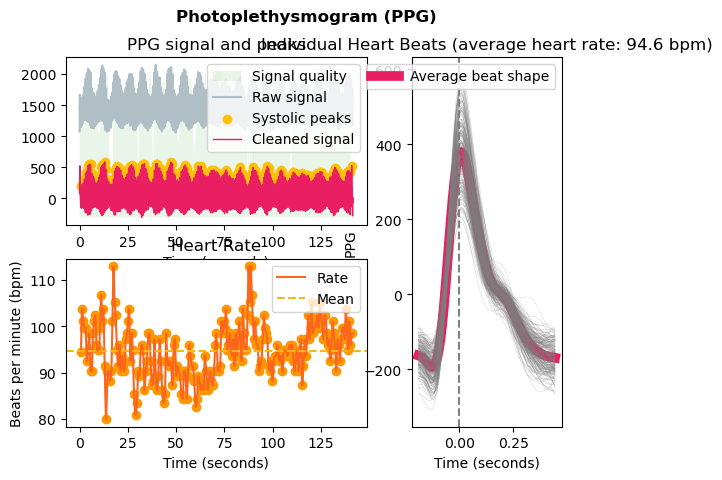

In [24]:
signals, info = nk.ppg_process(ppg.get_column("ppg_raw").to_numpy(), sampling_rate=128)

# Visualize the processing
nk.ppg_plot(signals, info)

<Axes: >

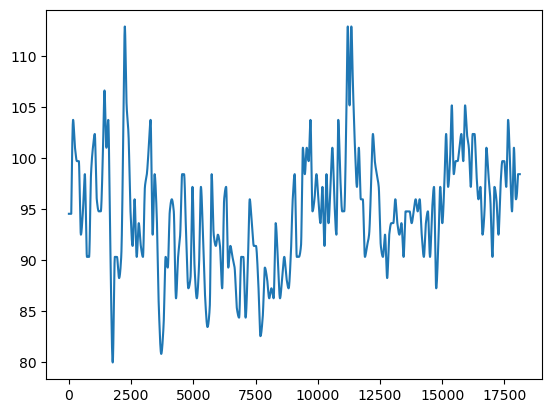

In [25]:
signals["PPG_Rate"].plot()

In [26]:
ppg_cleaned = nk.ppg_clean(
    ppg.get_column("ppg_raw").to_numpy(),
    sampling_rate=128,
)
quality = nk.ppg_quality(ppg_cleaned, sampling_rate=128, method="templatematch")

In [27]:
ppg_cleaned

array([ 89.35158114,  82.6779006 ,  77.67657258, ..., -13.53478915,
       -40.27051572, -70.96049987])

In [28]:
ppg.plot(x="timestamp", y="ppg_raw", kind="line", width=800, height=400)

:Curve   [timestamp]   (ppg_raw)

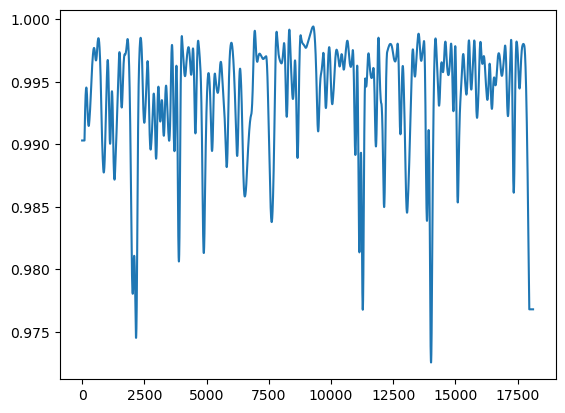

In [29]:
plt.plot(quality)